In [1]:
import environments
import numpy as np
from collections import deque
from collections import defaultdict
import matplotlib.pyplot as plt
from replaybuffer import *

from library import *
 
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
env1 = environments.environment_gym('Acrobot-v1')
env = environments.env_wrapper(env1)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
/Users/rezacolindoobary/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
n_action = env.action_size()

In [15]:
# testing the replay buffer storing facility
def store(env, n_episodes, replaybuffer, window = 100):
    scores = []
    moving_scores = deque(maxlen = window)
    moving_average_scores = []
    for i_epsiodes in range(0,n_episodes):
        print('\r','Episode [{}/{}]'.format(i_epsiodes, n_episodes),end='')
        done = False
        state = env.reset()
        score = 0
        while not done:
            next_action = env.env.action_space_sample()
            next_state, reward, done, _ = env.step(next_action)
            score+=reward
            replaybuffer.add(state,next_action, reward, next_state, done)
            state = next_state
        scores.append(score)
        moving_scores.append(score)
        moving_average_scores.append(np.mean(moving_scores))
    return np.mean(scores), scores, moving_average_scores, replaybuffer

In [6]:
rb = ReplayBuffer(action_size = n_action,buffer_size = 100,batch_size = 10,seed = 12345)
_ = store(env, 10, rb, window=100)

_ = rb.sample()
len(_[0]) == 10

 Episode [9/10]

True

 Episode [14/15]max -500.0


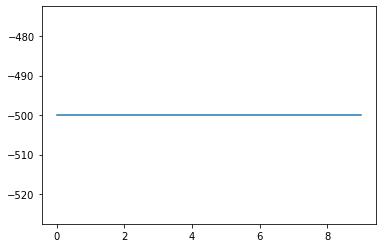

In [7]:

#random policy
#policy = lib.random()
#Q = defaultdict(lambda: np.zeros(n_actions))
mean_scores, score, moving_window, rb = store(env, 15,rb)
moving_window = moving_window[5:]
print('max',max(moving_window))
plt.plot(moving_window)
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class LinearModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(state_size, action_size)

    def forward(self,x):
        return self.linear(x)

In [5]:
class config:
    def __init__(self, **kwargs):
        self.__dict__ = kwargs


eps = epsilon(eps_start = 1.0, eps_decay = 0.9999, eps_min = 0.01)
policy = epsilon_greedy(eps,200)

class Agent():
    def __init__(self, state_size, action_size, model, optimiser, memory , config_data, seed = 122334):
        # configuration data
        self.config_data = config_data

        self.seed = seed
        self.state_size = state_size
        self.action_size = action_size

        # model definition
        self.model_local = model
        self.model_target = model
        self.optimizer = optimiser
        self.optimizer = self.optimizer(self.model_local.parameters(), lr = self.config_data.LR)

        # Replay memory
        self.memory = memory

        # update_time_learning_step
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.config_data.UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > self.config_data.BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, self.config_data.GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.model_local.eval()
        with torch.no_grad():
            action_values = self.model_local(state)
        self.model_local.train()

        # Epsilon-greedy action selection
        if np.random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            #print(action_values.cpu().data.numpy())
            return np.random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        next_states = torch.tensor(next_states).float()
        rewards = torch.tensor(rewards).float()
        actions = torch.tensor(actions).long()
        states = torch.tensor(states).float()
        dones = torch.tensor(dones).float()
            # Get max predicted Q values (for next states) from target model (without ddqn)
        Q_targets_next = self.model_target(next_states).detach().max(1)[0].unsqueeze(1)
    
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.model_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network 
        self.soft_update(self.model_local, self.model_target, self.config_data.TAU)                     

    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

def dqn(env, agent, n_episodes=10000, max_t=2000, eps_start=1.0, eps_end=0.01, \
        eps_decay=0.8, stop_at_goal = True, goal = None):
    """Deep Q-Learning. Returns the scores and the number of episodes required to solve the environment if stop_at_goal
    is true. If stop_at_goal is false, will return scores for n_episodes without stopping.
    
    Params
    ======
        env (env): Environment
        agent (Agent): The agent
        folder (string): the folder string name to deposit results
        is_train_mode (boolean):If train mode is on or not.
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        n_episodes (int) : Number of episodes
        max_t (int) : Maximum number of time steps considered
        stop_at_goal (boolean) : If true, will stop when environment is solved, else will continue for n_episodes
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved_in = None
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if stop_at_goal:
            if np.mean(scores_window)>=goal:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), "checkpoint.pth")
                solved_in = i_episode-100
                break
        elif i_episode==2000:
            torch.save(agent.model_local.state_dict(), "checkpoint_final.pth")
    return scores, solved_in


dqn_config_data = config(BUFFER_SIZE = int(1e5), BATCH_SIZE = 64, GAMMA = 0.99, TAU = 1e-3, LR = 5e-4, UPDATE_EVERY = 4)
env1 = environments.environment_gym('Acrobot-v1')
env = environments.env_wrapper(env1)
model = LinearModel(env.env.observation_space().shape[0],env.action_size())
optimiser = optim.Adam
rb = ReplayBuffer(action_size = n_action,buffer_size = dqn_config_data.BUFFER_SIZE, batch_size = dqn_config_data.BATCH_SIZE,seed = 122334)

agent = Agent(env.env.observation_space().shape[0],env.action_size(),model = model, optimiser = optimiser, memory = rb, config_data = dqn_config_data)
scores, solved_in = dqn(env, agent, stop_at_goal=False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 100	Average Score: -442.48
Episode 200	Average Score: -215.69
Episode 235	Average Score: -216.41

KeyboardInterrupt: 